# Add Folders to Path

We start by adding the necessary folders to the current working path.

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add PRA folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/PRA2D")

# add ActiveBarriers folder to current working path
sys.path.append(parent_directory+"/demos/ActiveBarriers")

# Overview

We illustrate the numerical implementation and the use of the active Finite Time Lyapunov Exponent (aFTLE) on 2-D homogeneous, isotropic turbulence. The active LCS diagnostic is applied to the two-dimensional and steady instantaneous linear momentum barrier equation. The notebook is structured as follows:

1. Import vorticity and velocity data stored in the folder 'data/Turbulence'. Make sure that all the necessary files are stored in the folder 'data/Turbulence'.
<br />
2. Define computational parameters (such as the number of cores) and variables.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. Apply active Polar Rotation Angle (aPRA) to instantaneous vorticity barrier equation:

   <br />
    
    For 2D incompressible, uniform-density Navier–Stokes flows, the Eulerian barrier equation for vorticity is an autonomous Hamiltonian system of the form:
    
    \begin{equation}
    \mathbf{x}'(s)=\nu \rho \mathbf{J} \nabla \dfrac{D}{Dt}\mathbf{\omega (\mathbf{x}}, t),
    \label{eq: vorticity} 
    \end{equation}
    
    Time 't' is just a fixed parameter and hence the system is autonomous and the integration is done with respect to a dummy time variable 's'. 's' can be arbitrarily large and the aPRA is only limited by the spatial resolution and domain. It can thus potentially reveal finer and more resolved structures compared to the classic version of the PRA, which is trivially zero in the instantaneous limit and hence does not succeed in higlighting elliptic barriers.
    
    <br />
    
   * We start by evaluating the right-hand-side of equation \ref{eq: vorticity} by interpolating $ \mathbf{J} \nabla \dfrac{D}{Dt}\mathbf{\omega (\mathbf{x}}, t) $ over the spatial meshgrid.
   
   <br />
   
   * We then apply the aFTLE to the autonomous ODE from equation \ref{eq: vorticity} on different 'dummy' time-intervals. 

# Import Data

In [2]:
%%time
# import scipy
import scipy.io

# import numpy
import numpy as np

# load vorticity data
turb_w = parent_directory + r'/data/Turbulence/turb_w'

# iterate over all files in folder 'turb_w' and load vorticity data
i = 0

omega = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_w)):
    if filename.endswith(".mat"):
        file_w = os.path.join(turb_w, filename)
        mat_turb_w = scipy.io.loadmat(file_w)
        omega[:,:,i] = mat_turb_w['w']
        i+=1

# load velocity data
turb_u = parent_directory + r'/data/Turbulence/turb_u'
      
# iterate over all files in folder 'turb_u' and load velocity data
i = 0
U = np.zeros((1024, 1024, 251))
V = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_u)):
    if filename.endswith(".mat"):
        file_u = os.path.join(turb_u, filename)
        mat_turb_u = scipy.io.loadmat(file_u)
        U[:,:,i] = mat_turb_u['u1']
        V[:,:,i] = mat_turb_u['u2']
        i+=1
        
# load x/y grid
X = scipy.io.loadmat(parent_directory + r'/data/Turbulence/grid.mat')['x']
Y = X.copy().transpose()

CPU times: user 34.2 s, sys: 1.96 s, total: 36.1 s
Wall time: 36.1 s


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# Number of cores for parallel computing
Ncores = 18

# time-interval over which data is defined
time_data = np.linspace(0, 25, 251, endpoint = True).reshape(1, -1)

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

In [4]:
# specify time at which to compute instantaneous momentum barriers (this should an integer in [0, 249])
t0 = 0

# specify domain over which to compute linear momentum barriers
x_domain = np.linspace(4.2, 5, 300)
y_domain = np.linspace(2.2, 3, 300)

# grid spacing
dx = x_domain[1]-x_domain[0]
dy = y_domain[1]-y_domain[0]

#compute meshgrid
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# define dummy time interval
ds = 0.001
sN = 0.25 # Feel free to change this parameter as needed
s_dummy = np.arange(0, sN+ds, ds)

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # float between [1/100, 1/5]
aux_grid = [aux_grid_ratio*dx, aux_grid_ratio*dy] # list (2, )

# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

CPU times: user 41.8 s, sys: 827 ms, total: 42.6 s
Wall time: 42.6 s


# Instantaneous vorticity barriers

We visualize elliptic (closed) vorticity barriers by applying the PRA to the trajectories of system \ref{eq: vorticity}. Whenever the PRA is applied to an active vector field, such as vorticity, we refer to it as aPRA (active PRA).

In [6]:
%%time
# Import interpolation function for instantaneous active momentum barrier equation
from ipynb.fs.defs.InstantaneousActiveVorticity import InstantaneousActiveVorticity

# Interpolate RHS of vorticity barrier equation using cubic spline interpolation
Interpolant_vorticity = InstantaneousActiveVorticity(t0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid, Ncores)

  0%|          | 0/1024 [00:00<?, ?it/s]

CPU times: user 3min 34s, sys: 2min 19s, total: 5min 53s
Wall time: 4min 6s


## Compute active PRA

We now compute the active PRA for the instantaneous vorticity barrier equations. First, we evaluate the active Cauchy-Green strain tensor from the gradient of the active flow map over the meshgrid. The active flow map is given by the solution of the autonomous ODE from equation \ref{eq: vorticity}. Finally, we apply the classic PRA to the active Cauchy-Green strain tensor.

In [7]:
%%time
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import package to compute Polar Rotation Angle (PRA)
from ipynb.fs.defs.PRA import _PRA

# Import package for parallel computing
from joblib import Parallel, delayed

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def parallel_aPRA(x0_batch, y0_batch, s_dummy, s):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch]) # array (2, Nx*Ny)

    # Compute gradient of flow map
    DF = gradient_flowmap(s_dummy, X0, X, Y, Interpolant_vorticity[0], Interpolant_vorticity[1], periodic, defined_domain, False, s_dummy.reshape(1,-1), aux_grid) # array (Nt, 2, 2, Nx*Ny)

    aPRA = np.zeros((len(s), DF.shape[-1]))
    
    counter = 0
    for idx in np.searchsorted(s_dummy, s):
        
        # Extract gradient from s0 to si
        DF_s0_si = DF[idx,:, :, :] # array (Nt, 2, 2, Nx*Ny)
        
        for i in range(DF.shape[3]):
            
            # Compute active PRA
            aPRA[counter, i] = _PRA(DF_s0_si[:,:,i])
            
        counter += 1
    
    return aPRA

CPU times: user 240 ms, sys: 53.9 ms, total: 294 ms
Wall time: 294 ms


In [8]:
%%time
# Define dummy time-intervals for computation of aFTLE
s1 = 0
s2 = 0.05
s3 = 0.15
s4 = 0.25

s = [s1, s2, s3, s4]

# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, )
x0 = X_domain.ravel() # array (Nx*Ny,)
y0 = Y_domain.ravel() # array (Nx*Ny,)

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny)

results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(parallel_aPRA)(x0_batch[i], y0_batch[i], s_dummy, s) for i in range(len(x0_batch)))

# Extract aPRA from results of parallel computing
aPRA = results[0]

for res in results[1:]:
    aPRA = np.append(aPRA, res, axis = 1)

[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=18)]: Done   2 out of  18 | elapsed:  1.1min remaining:  9.0min
[Parallel(n_jobs=18)]: Done   3 out of  18 | elapsed:  1.1min remaining:  5.6min
[Parallel(n_jobs=18)]: Done   4 out of  18 | elapsed:  1.1min remaining:  3.9min
[Parallel(n_jobs=18)]: Done   5 out of  18 | elapsed:  1.1min remaining:  2.9min
[Parallel(n_jobs=18)]: Done   6 out of  18 | elapsed:  1.1min remaining:  2.3min
[Parallel(n_jobs=18)]: Done   7 out of  18 | elapsed:  1.1min remaining:  1.8min
[Parallel(n_jobs=18)]: Done   8 out of  18 | elapsed:  1.1min remaining:  1.4min
[Parallel(n_jobs=18)]: Done   9 out of  18 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=18)]: Done  10 out of  18 | elapsed:  1.1min remaining:   54.2s
[Parallel(n_jobs=18)]: Done  11 out of  18 | elapsed:  1.1min remaining:   43.2s
[Parallel(n_jobs=18)]: Done  12 out of  18 | elapse

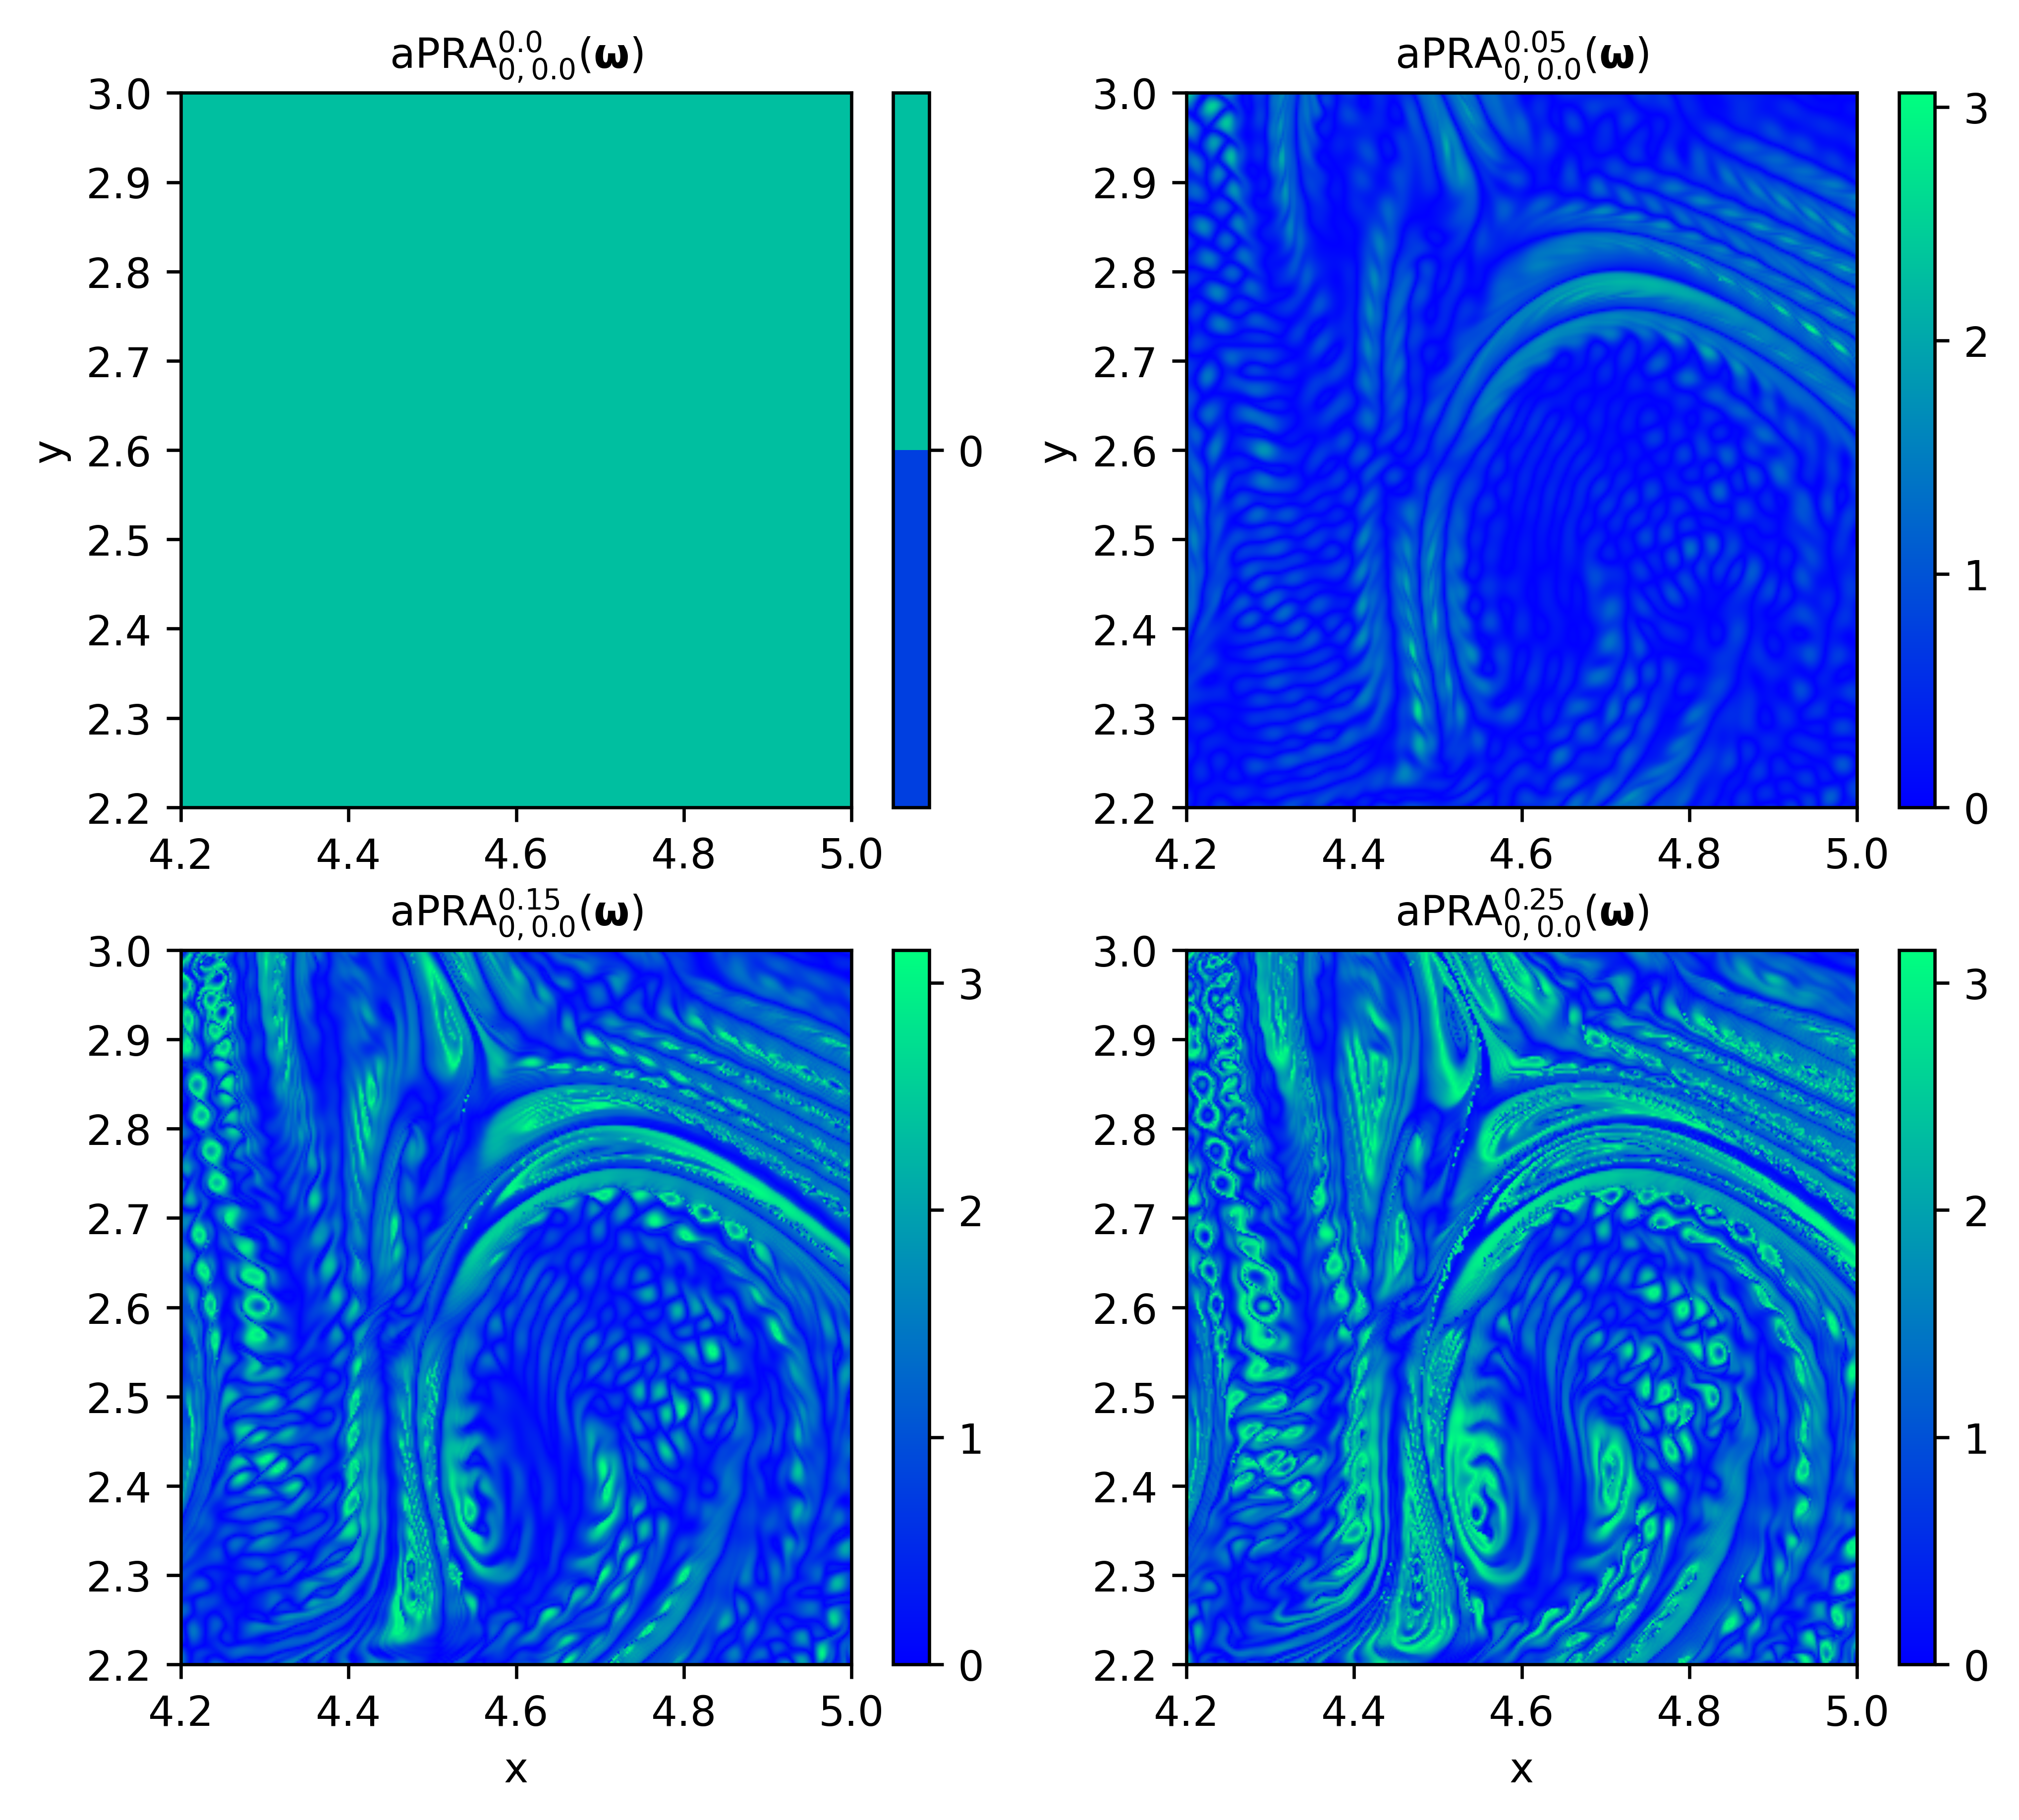

In [9]:
################################################ PLOT RESULTS ################################################

# Import plotting library
import matplotlib.pyplot as plt

# Figure/Axis
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, dpi = 600, figsize=(8, 7))

# Contourplot of aPRA_0^0 over meshgrid of initial conditions
cax = ax0.tricontourf(x0, y0, aPRA[0,:], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax0, ticks = np.linspace(0, 3, 4))

# Contourplot of aPRA_0^0.05 over meshgrid of initial conditions
cax = ax1.tricontourf(x0, y0, aPRA[1,:], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax1, ticks = np.linspace(0, 3, 4))

# Contourplot of aPRA_0^0.15 over meshgrid of initial conditions
cax = ax2.tricontourf(x0, y0, aPRA[2,:], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax2, ticks = np.linspace(0, 3, 4))

# Contourplot of aPRA_0^0.25 over meshgrid of initial conditions
cax = ax3.tricontourf(x0, y0, aPRA[3,:], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax3, ticks = np.linspace(0, 3, 4))
# Axis Labels
ax2.set_xlabel("x", fontsize = 10)
ax3.set_xlabel("x", fontsize = 10)
ax0.set_ylabel("y", fontsize = 10)
ax1.set_ylabel("y", fontsize = 10)

ax0.set_title(r'$ \mathrm{aPRA}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[0])], 2)}}}$'+r'($ \mathbf{\omega}$)', fontsize = 10)
ax1.set_title(r'$ \mathrm{aPRA}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[1])], 2)}}}$'+r'($ \mathbf{\omega}$)', fontsize = 10)
ax2.set_title(r'$ \mathrm{aPRA}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[2])], 2)}}}$'+r'($ \mathbf{\omega}$)', fontsize = 10)
ax3.set_title(r'$ \mathrm{aPRA}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[3])], 2)}}}$'+r'($ \mathbf{\omega}$)', fontsize = 10)

plt.show()

The figures focus on elliptic active barriers to vorticity in one of the vortical regions of the two-dimensional turbulence model. When applied to the instantaneous vorticity barrier equation, the aPRA reveals several small scale closed elliptic barriers to vorticity.

# References

[1] Haller, G., Katsanoulis, S., Holzner, M., Frohnapfel, B., & Gatti, D. (2020). Objective barriers to the transport of dynamically active vector fields. Journal of Fluid Mechanics, 905.

[2] Notebook 9.7.5. in "Transport Barriers and Coherent Structures in Flow Data" by George Haller.